- Importación de librerías


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- Carga de datos de Yahoo Finance

In [2]:
stock_data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
stock_prices = stock_data['Close'].values  # Using closing prices

[*********************100%%**********************]  1 of 1 completed


## SARSA

In [3]:
# Definición de parámetros
num_states = 100  
num_actions = 3  
epsilon = 0.1  
learning_rate = 0.1  
discount = 0.95  
episodes = 1000
episodes_display = 100

In [4]:
# Inicialización Q-table
q_table = np.zeros((num_states, num_actions))

# Función de discretización para convertir el precio de la acción a valor discreto
def discretised_state(price, price_range):
    return min(int(price / price_range * num_states), num_states - 1)

# Elección de acción basado en el estado actual (política e-greedy) 
def choose_action(curr_discrete_state):
    if np.random.rand() < epsilon:
        return np.random.randint(0, num_actions)  # Exploración
    else:
        return np.argmax(q_table[curr_discrete_state])  # Explotación

# Función de recompensa
def get_reward(action, price_change):
    if action == 0:  # Buy
        return price_change
    elif action == 2:  # Sell
        return -price_change
    else:  # Hold
        return 0

# Inicialización de la tabla de recompensa
price_range = max(stock_prices) - min(stock_prices)
ep_rewards = []
ep_rewards_table = {'ep': [], 'avg': [], 'min': [], 'max': []}

for episode in range(episodes):
    episode_reward = 0
    state_array = stock_prices[0]  # Obtener solo el array del estado
    curr_discrete_state = discretised_state(state_array, price_range)  # Estado inicial del entorno discretizado
    action = choose_action(curr_discrete_state)  # Elección de la acción inicial
    done = False
    i = 0  # Contador para el paso del tiempo
    
    # Determinar si se debe renderizar el estado en este episodio
    if episode % episodes_display == 0:
        render_state = True
    else:
        render_state = False

    while not done:
        if i < len(stock_prices) - 1:
            new_state_array = stock_prices[i + 1]
            reward = get_reward(action, new_state_array - state_array)
            new_discrete_state = discretised_state(new_state_array, price_range)
            new_action = choose_action(new_discrete_state)  # Elección de la nueva acción
            done = False
        else:
            new_state_array = state_array
            reward = 0
            new_discrete_state = curr_discrete_state
            new_action = action
            done = True
        
        # Actualizar la tabla Q usando SARSA
        if not done:
            current_q = q_table[curr_discrete_state, action]  # Valor Q actual asociado con la acción actual
            next_q = q_table[new_discrete_state, new_action]  # Valor Q de la próxima acción
            new_q = current_q + learning_rate * (reward + discount * next_q - current_q)  # Actualizar los valores en la tabla Q
            q_table[curr_discrete_state, action] = new_q
    
        i += 1
        curr_discrete_state = new_discrete_state
        action = new_action
        episode_reward += reward

    ep_rewards.append(episode_reward)
    
    if not episode % episodes_display: 
        avg_reward = sum(ep_rewards[-episodes_display:])/len(ep_rewards[-episodes_display:])  # Si el número actual es divisible, mostrar resultado        
        ep_rewards_table['ep'].append(episode)
        ep_rewards_table['avg'].append(avg_reward)
        ep_rewards_table['min'].append(min(ep_rewards[-episodes_display:]))
        ep_rewards_table['max'].append(max(ep_rewards[-episodes_display:]))          
        print(f"Episode:{episode} avg:{avg_reward} min:{min(ep_rewards[-episodes_display:])} max:{max(ep_rewards[-episodes_display:])}")


Episode:0 avg:57518.278774261475 min:57518.278774261475 max:57518.278774261475
Episode:100 avg:59482.13633846283 min:55353.29149246216 max:61581.4462852478
Episode:200 avg:59971.4421087265 min:57336.36386489868 max:61960.931270599365
Episode:300 avg:59975.975674324036 min:57228.071407318115 max:61973.631286621094
Episode:400 avg:59931.69853839874 min:57719.76884460449 max:62715.77125167847
Episode:500 avg:59985.14237819672 min:57055.46375656128 max:62751.14628982544
Episode:600 avg:60067.49380363464 min:57099.00392913818 max:62146.85383224487
Episode:700 avg:59911.50469207764 min:56933.9313621521 max:62239.398822784424
Episode:800 avg:60056.72551052093 min:58071.971336364746 max:61725.60879898071
Episode:900 avg:59839.06418003082 min:56720.333892822266 max:61771.61138153076


In [5]:
# Guardar tabla Q
q_table_df = pd.DataFrame(q_table, columns=["Buy", "Hold", "Sell"])
q_table_df.to_csv('q_table_sarsa.csv', index=False)

print(q_table_df)

ep_rewards_df = pd.DataFrame(ep_rewards_table)
print(ep_rewards_df)


            Buy         Hold         Sell
0      0.000000     0.000000     0.000000
1      0.000000     0.000000     0.000000
2      0.000000     0.000000     0.000000
3      0.000000     0.000000     0.000000
4      0.000000     0.000000     0.000000
..          ...          ...          ...
95  1274.290358  1202.467583  1102.445333
96  1331.152466  1233.517052  1232.122084
97  1458.172244  1417.888881  1338.675594
98  1407.610440  1354.063531  1272.200416
99  1737.998608  1398.492999  1363.753393

[100 rows x 3 columns]
    ep           avg           min           max
0    0  57518.278774  57518.278774  57518.278774
1  100  59482.136338  55353.291492  61581.446285
2  200  59971.442109  57336.363865  61960.931271
3  300  59975.975674  57228.071407  61973.631287
4  400  59931.698538  57719.768845  62715.771252
5  500  59985.142378  57055.463757  62751.146290
6  600  60067.493804  57099.003929  62146.853832
7  700  59911.504692  56933.931362  62239.398823
8  800  60056.725511  58071.971

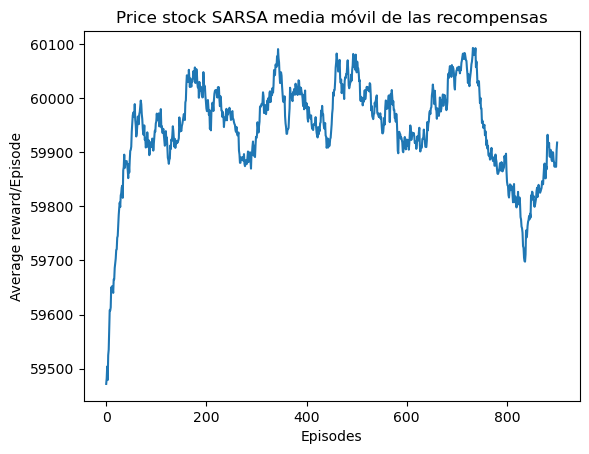

In [8]:
window_size = 100
# A continuación, se multiplican los valores de la ventana por los valores de la recompensas obtenidas y posteriormente
# se suma todo
moving_avg_rewards = np.convolve(ep_rewards, np.ones(window_size)/window_size, mode='valid') #para que todos los valores en la ventana sumen 1
                                                                 # mode=valid para que solo multiplique aquellas secuencias que se superpongan
                                                                # completamente.

# Graficamos la recompensa promedio móvil
plt.plot(np.arange(len(moving_avg_rewards)), moving_avg_rewards)
plt.title('Price stock SARSA media móvil de las recompensas')
plt.ylabel('Average reward/Episode')
plt.xlabel('Episodes')
plt.show()

In [7]:
# Calculamos la tasa de convergencia 
convergence_rate = (ep_rewards_table['avg'][-1] - ep_rewards_table['avg'][0]) / len(ep_rewards_table['avg'])
print("Tasa de convergencia:", convergence_rate)

Tasa de convergencia: 232.07854057693476
